In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

np.random.seed(1234)

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

print("\nSuccessfully imported packages\n")

Populating the interactive namespace from numpy and matplotlib

Successfully imported packages



In [2]:
# network can be 'MINE' or 'CROP'
network = 'MINE'

if network == 'CROP':
    nx=572
    ny=572
    
if network == 'MINE':
    nx = 128
    ny = 128

sigma = 10

plateau_min = -2
plateau_max = 2

r_min = 1
r_max = 200

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def create_image_and_label(nx,ny):
    x = np.floor(np.random.rand(1)[0]*nx)
    y = np.floor(np.random.rand(1)[0]*ny)

    image = np.ones((nx,ny))
    label = np.ones((nx,ny))
    image[x,y] = 0
    image_distance = ndimage.morphology.distance_transform_edt(image)

    r = np.random.rand(1)[0]*(r_max-r_min)+r_min
    plateau = np.random.rand(1)[0]*(plateau_max-plateau_min)+plateau_min

    label[image_distance <= r] = 0 
    label[image_distance > r] = 1
    label = (1 - label)
    
    image_distance[image_distance <= r] = 0 
    image_distance[image_distance > r] = 1
    image_distance = (1 - image_distance)*plateau

    image = image_distance + np.random.randn(nx,ny)/sigma
    #image = rgb2gray(image)
    
    if network == 'MINE':
        return image, 0, label
    if network == 'CROP':
        return image, label[92:nx-92,92:ny-92], label

def create_batch(nx,ny,n_image):
    
    X = np.zeros((n_image,nx,ny))
    if network == 'CROP':
        Y = np.zeros((n_image,nx-184,ny-184))
    if network == 'MINE':
        Y = np.zeros((n_image))
    Y_full = np.zeros((n_image,nx,ny))
    
    for i in range(n_image):
        if network == 'CROP':
            X[i,:,:],Y[i,:,:],Y_full[i,:,:] = create_image_and_label(nx,ny)
        if network == 'MINE':
            X[i,:,:],_,Y_full[i,:,:] = create_image_and_label(nx,ny)

    return X,Y,Y_full

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


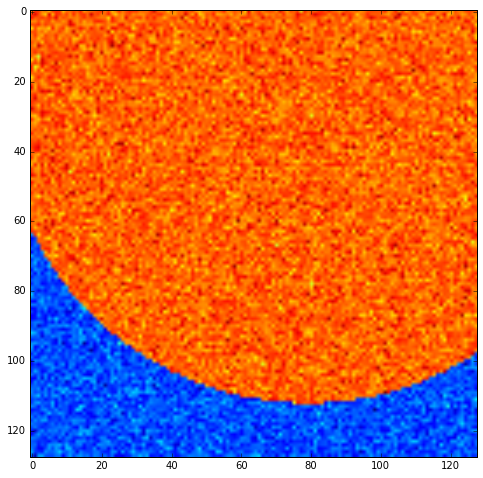

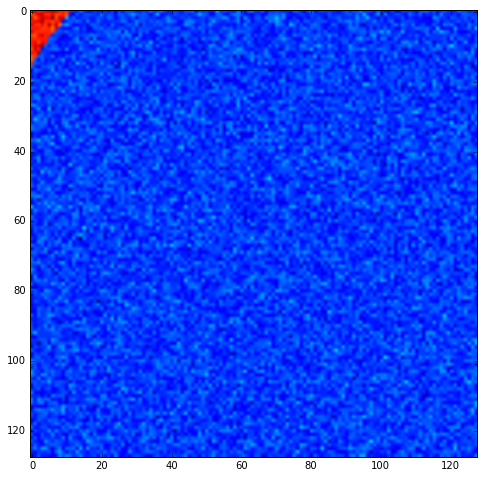

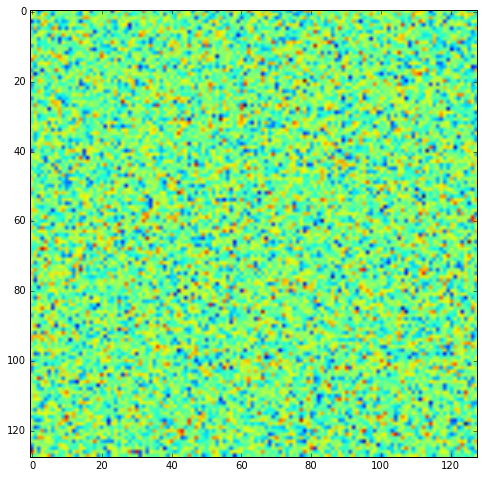

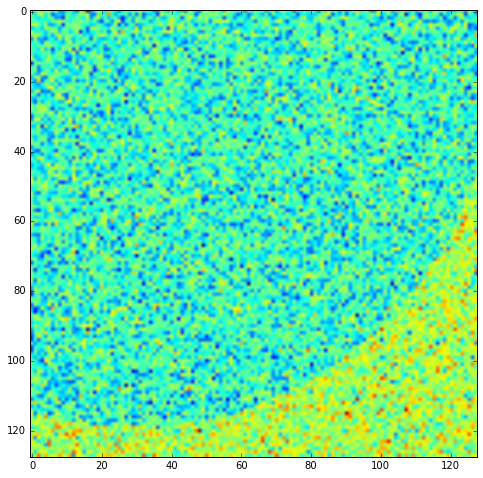

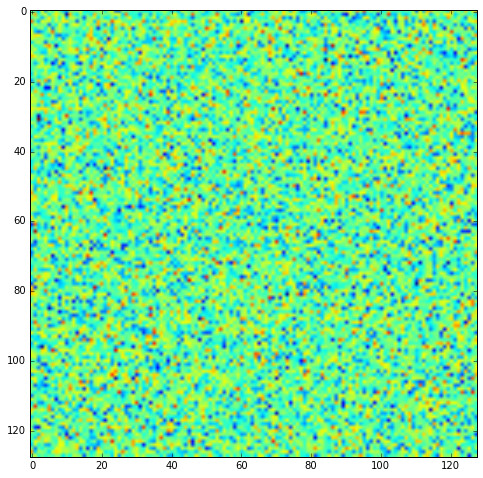

In [3]:
X,Y,Y_full = create_batch(nx,ny,5)

for i in range(5):
    plt.imshow(X[i,:,:])
    #plt.contour(Y[i,:,:,1],colors='black',linewidths=6)
    plt.show()

In [4]:
batch = 1
image_batch_input = tf.placeholder("float", shape=[batch, nx, ny])
image_batch = tf.reshape(image_batch_input, [batch,nx,ny,1])

keep_prob = tf.placeholder("float")
phase_train = tf.placeholder(tf.bool, name='phase_train')

label_batch_input = tf.placeholder("float", shape=[batch, nx, ny])
label_batch = tf.reshape(label_batch_input, [batch,nx,ny,1])

if network == 'CROP':
    crop_label_batch_input = tf.placeholder("float", shape=[batch, nx-184, ny-184])
    crop_label_batch = tf.reshape(crop_label_batch_input, [batch,nx-184,ny-184,1])

In [5]:
(((nx-180)/2+4)/2+4)/2+4

0

In [6]:
# For a square image nxn, the resulting prediction is of size (n-184)x(n-184)

n_class = 2
chanel_root = 32
field_of_view = 3
max_pool_size = 2

iterations = 10000
n_image = batch

def get_deconv_filter(f_shape):
    width = f_shape[0]
    height = f_shape[1]
    f = math.ceil(width/2.0)
    c = (2 * f - 1 - f % 2) / (2.0 * f)
    bilinear = np.zeros([f_shape[0], f_shape[1]])
    for x in range(width):
        for y in range(height):
            value = (1 - abs(x / f - c)) * (1 - abs(y / f - c))
            bilinear[x, y] = value
    weights = np.zeros(f_shape)
    for i in range(f_shape[2]):
        weights[:, :, i, i] = bilinear

    filt = tf.zeros_initializer(shape=weights.shape, dtype=tf.float32)
    filt = filt + weights
    return filt + 1e-4

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def weight_variable_devonc(shape):
    #initial = 1.0/float(shape[0]*shape[1])
    #return tf.Variable(tf.add((np.ones(shape)*initial).astype(float32),tf.truncated_normal(shape, stddev=0.1)))
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    #return get_deconv_filter(shape)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W,keep_prob_=None):
    conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    if keep_prob_ is not None:
        conv_2d = tf.nn.dropout(conv_2d, keep_prob_)
    return conv_2d

def deconv2d(x, W,stride):
    output_shape = tf.pack([tf.shape(x)[0], tf.shape(x)[1]*2, tf.shape(x)[2]*2, tf.shape(x)[3]/2])
    return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID')

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2,output_shape):
    #x1.set_shape(input_shape)
    x1_crop = tf.image.extract_glimpse(x1, [output_shape[1], output_shape[2]],np.zeros([output_shape[0],2]),centered=True)
    #x1_crop = tf.image.extract_glimpse(x1, [tf.shape(x2)[1], tf.shape(x2)[2]],tf.shape(x2)[0])
    return tf.concat(3,[x1_crop,x2]) 

def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    evidence = tf.add(exponential_map,tf.reverse(exponential_map,[False,False,False,True]))
    return tf.div(exponential_map,evidence)

def relaxed_dice(y_,output_map,shape):
    epsilon = 1e-10
    slice_y = tf.slice(y_,[0,0,0,1],[shape[0],shape[1],shape[2],1])
    slice_output_map = tf.slice(output_map,[0,0,0,1],[shape[0],shape[1],shape[2],1])
    
    intersection = tf.reduce_sum(tf.mul(slice_y,slice_output_map),[1,2])
    average = tf.reduce_sum(tf.div(tf.add(slice_y,slice_output_map),tf.constant([2.0])),[1,2])
    
    dice = tf.div(intersection,tf.add(average,tf.constant([epsilon])))
    
    return tf.reduce_mean(dice)

if network == 'CROP':
    # Convolution 1
    W_conv1 = weight_variable([field_of_view, field_of_view, 1, chanel_root])
    b_conv1 = bias_variable([chanel_root])
    h_conv1 = tf.nn.relu(conv2d(image_batch, W_conv1,None) + b_conv1)

    # Convolution 2
    W_conv2 = weight_variable([field_of_view, field_of_view, chanel_root, chanel_root])
    b_conv2 = bias_variable([chanel_root])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2,keep_prob) + b_conv2)

    # Max Pool 1
    h_pool1 = max_pool(h_conv2, max_pool_size)

    # Convolution 3
    W_conv3 = weight_variable([field_of_view, field_of_view, chanel_root, 2*chanel_root])
    b_conv3 = bias_variable([2*chanel_root])
    h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3,None) + b_conv3)

    # Convolution 4
    W_conv4 = weight_variable([field_of_view, field_of_view, 2*chanel_root, 2*chanel_root])
    b_conv4 = bias_variable([2*chanel_root])
    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4,keep_prob) + b_conv4)

    # Max Pool 2
    h_pool2 = max_pool(h_conv4, max_pool_size)

    # Convolution 5
    W_conv5 = weight_variable([field_of_view, field_of_view, 2*chanel_root, 4*chanel_root])
    b_conv5 = bias_variable([4*chanel_root])
    h_conv5 = tf.nn.relu(conv2d(h_pool2, W_conv5,None) + b_conv5)

    # Convolution 6
    W_conv6 = weight_variable([field_of_view, field_of_view, 4*chanel_root, 4*chanel_root])
    b_conv6 = bias_variable([4*chanel_root])
    h_conv6 = tf.nn.relu(conv2d(h_conv5, W_conv6,keep_prob) + b_conv6)

    # Max Pool 3
    h_pool3 = max_pool(h_conv6, max_pool_size)

    # Convolution 7
    W_conv7 = weight_variable([field_of_view, field_of_view, 4*chanel_root, 8*chanel_root])
    b_conv7 = bias_variable([8*chanel_root])
    h_conv7 = tf.nn.relu(conv2d(h_pool3, W_conv7,None) + b_conv7)

    # Convolution 8
    W_conv8 = weight_variable([field_of_view, field_of_view, 8*chanel_root, 8*chanel_root])
    b_conv8 = bias_variable([8*chanel_root])
    h_conv8 = tf.nn.relu(conv2d(h_conv7, W_conv8,keep_prob) + b_conv8)

    # Max Pool 4
    h_pool4 = max_pool(h_conv8, max_pool_size)

    # Convolution 9
    W_conv9 = weight_variable([field_of_view, field_of_view, 8*chanel_root, 16*chanel_root])
    b_conv9 = bias_variable([16*chanel_root])
    h_conv9 = tf.nn.relu(conv2d(h_pool4, W_conv9,None) + b_conv9)

    # Convolution 10
    W_conv10 = weight_variable([field_of_view, field_of_view, 16*chanel_root, 16*chanel_root])
    b_conv10 = bias_variable([16*chanel_root])
    h_conv10 = tf.nn.relu(conv2d(h_conv9, W_conv10,keep_prob) + b_conv10)

    # Deconvolution 1
    W_deconv_1 = weight_variable_devonc([max_pool_size, max_pool_size, 8*chanel_root, 16*chanel_root])
    b_deconv1 = bias_variable([8*chanel_root])
    h_deconv1 = tf.nn.relu(deconv2d(h_conv10, W_deconv_1, max_pool_size) + b_deconv1)
    h_deconv1_concat = crop_and_concat(h_conv8,h_deconv1,[n_image,(((nx-180)/2+4)/2+4)/2+4,(((ny-180)/2+4)/2+4)/2+4,8*chanel_root])

    # Convolution 11
    W_conv11 = weight_variable([field_of_view, field_of_view, 16*chanel_root, 8*chanel_root])
    b_conv11 = bias_variable([8*chanel_root])
    h_conv11 = tf.nn.relu(conv2d(h_deconv1_concat, W_conv11,None) + b_conv11)

    # Convolution 12
    W_conv12 = weight_variable([field_of_view, field_of_view, 8*chanel_root, 8*chanel_root])
    b_conv12 = bias_variable([8*chanel_root])
    h_conv12 = tf.nn.relu(conv2d(h_conv11, W_conv12,keep_prob) + b_conv12)

    # Deconvolution 2
    W_deconv_2 = weight_variable_devonc([max_pool_size, max_pool_size, 4*chanel_root, 8*chanel_root])
    b_deconv2 = bias_variable([4*chanel_root])
    h_deconv2 = tf.nn.relu(deconv2d(h_conv12, W_deconv_2, max_pool_size) + b_deconv2)
    h_deconv2_concat = crop_and_concat(h_conv6,h_deconv2,[n_image,((nx-180)/2+4)/2+4,((ny-180)/2+4)/2+4,4*chanel_root])

    # Convolution 13
    W_conv13 = weight_variable([field_of_view, field_of_view, 8*chanel_root, 4*chanel_root])
    b_conv13 = bias_variable([4*chanel_root])
    h_conv13 = tf.nn.relu(conv2d(h_deconv2_concat, W_conv13,None) + b_conv13)

    # Convolution 14
    W_conv14 = weight_variable([field_of_view, field_of_view, 4*chanel_root, 4*chanel_root])
    b_conv14 = bias_variable([4*chanel_root])
    h_conv14 = tf.nn.relu(conv2d(h_conv13, W_conv14,keep_prob) + b_conv14)

    # Deconvolution 3
    W_deconv_3 = weight_variable_devonc([max_pool_size, max_pool_size, 2*chanel_root, 4*chanel_root])
    b_deconv3 = bias_variable([2*chanel_root])
    h_deconv3 = tf.nn.relu(deconv2d(h_conv14, W_deconv_3, max_pool_size) + b_deconv3)
    h_deconv3_concat = crop_and_concat(h_conv4,h_deconv3,[n_image,(nx-180)/2+4,(ny-180)/2+4,2*chanel_root])

    # Convolution 15
    W_conv15 = weight_variable([field_of_view, field_of_view, 4*chanel_root, 2*chanel_root])
    b_conv15 = bias_variable([2*chanel_root])
    h_conv15 = tf.nn.relu(conv2d(h_deconv3_concat, W_conv15, None) + b_conv15)

    # Convolution 16
    W_conv16 = weight_variable([field_of_view, field_of_view, 2*chanel_root, 2*chanel_root])
    b_conv16 = bias_variable([2*chanel_root])
    h_conv16 = tf.nn.relu(conv2d(h_conv15, W_conv16,keep_prob) + b_conv16)

    # Deconvolution 4
    W_deconv_4 = weight_variable_devonc([max_pool_size, max_pool_size, chanel_root, 2*chanel_root])
    b_deconv4 = bias_variable([chanel_root])
    h_deconv4 = tf.nn.relu(deconv2d(h_conv16, W_deconv_4, max_pool_size) + b_deconv4)
    h_deconv4_concat = crop_and_concat(h_conv2,h_deconv4,[n_image,nx-180,ny-180,chanel_root])

    # Convolution 17
    W_conv17 = weight_variable([field_of_view, field_of_view, 2*chanel_root, chanel_root])
    b_conv17 = bias_variable([chanel_root])
    h_conv17 = tf.nn.relu(conv2d(h_deconv4_concat, W_conv17, None) + b_conv17)

    # Convolution 18
    W_conv18 = weight_variable([field_of_view, field_of_view, chanel_root, chanel_root])
    b_conv18 = bias_variable([chanel_root])
    h_conv18 = tf.nn.relu(conv2d(h_conv17, W_conv18,keep_prob) + b_conv18)

    # Output Map
    W_conv19 = weight_variable([1, 1, chanel_root, n_class])
    b_conv19 = bias_variable([n_class])
    h_conv19 = tf.nn.relu(conv2d(h_conv18, W_conv19, None) + b_conv19)
    #h_conv19 = tf.nn.relu(conv2d(h_conv18, W_conv19, None))

    #first shift the values of f so that the highest number is 0
    #max_val = tf.reduce_max(h_conv19)
    #h_conv19 = h_conv19 - max_val
    
    output_map = pixel_wise_softmax(h_conv19)
    pred = tf.argmax(output_map, dimension=3)

    net_parts = {
    'pool1': h_pool1,
    'pool2': h_pool2,
    'pool3': h_pool3,
    'pool4': h_pool4,
    'last_downconv': h_conv10,

    'deconv1': h_deconv1,
    'deconv2': h_deconv2,
    'deconv3': h_deconv3,
    'deconv4': h_deconv4,
    }

In [7]:
import nerveseg_input
import nerveseg
batch = 1

FLAGS = tf.app.flags.FLAGS
FLAGS.batch_size = batch


if network == 'MINE':
    output_map, pred, net_parts = nerveseg.inference(image_batch, keep_prob, phase_train)

Class ratio: 0.0120589042214


In [8]:
X, Y, Y_full = create_batch(nx,ny,batch)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

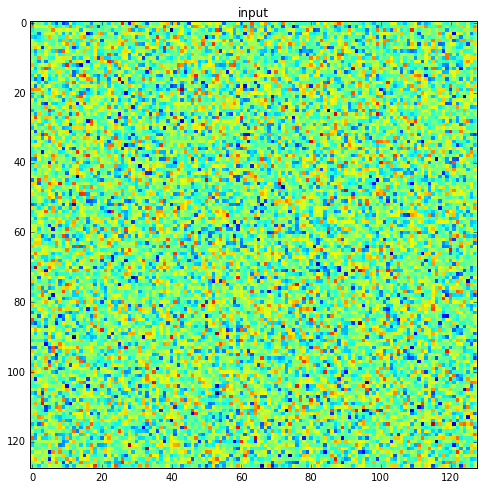

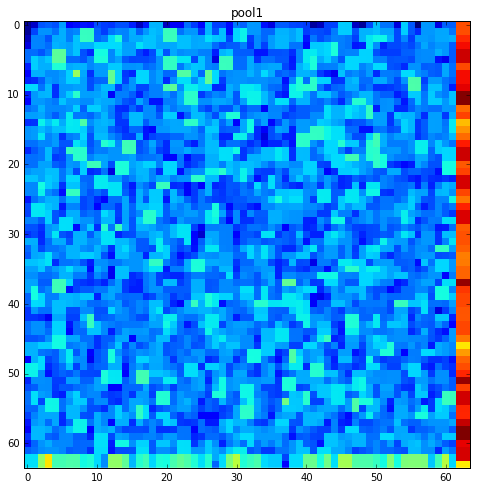

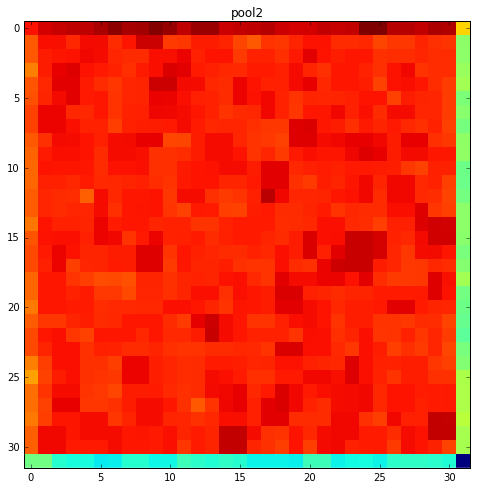

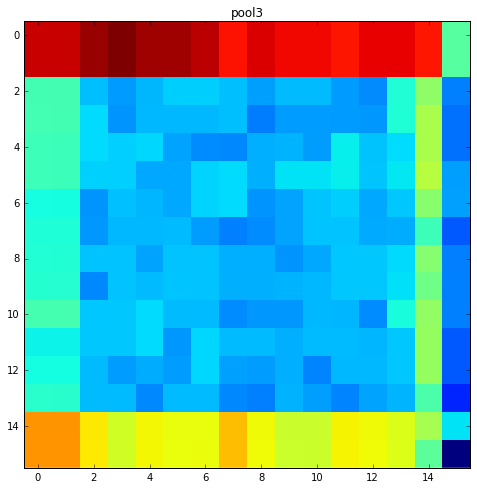

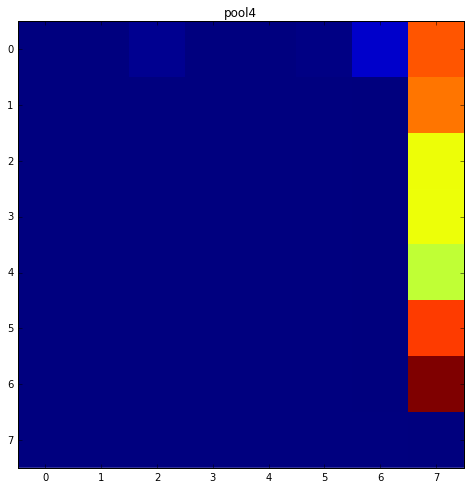

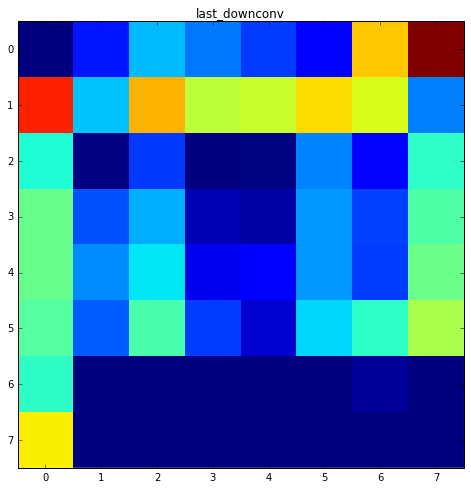

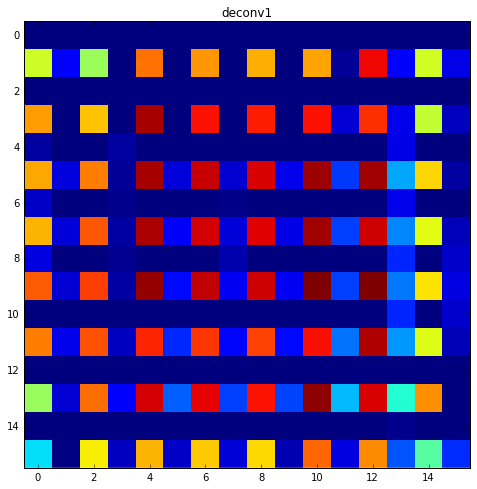

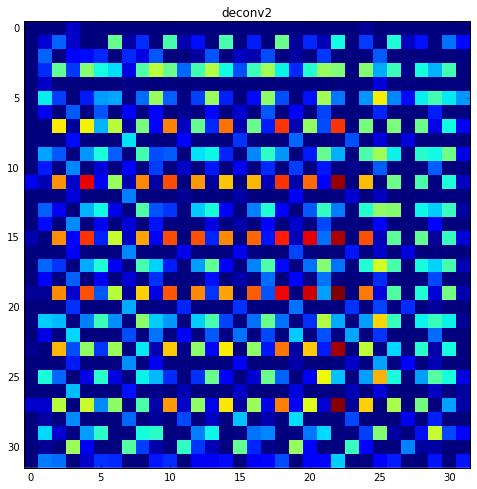

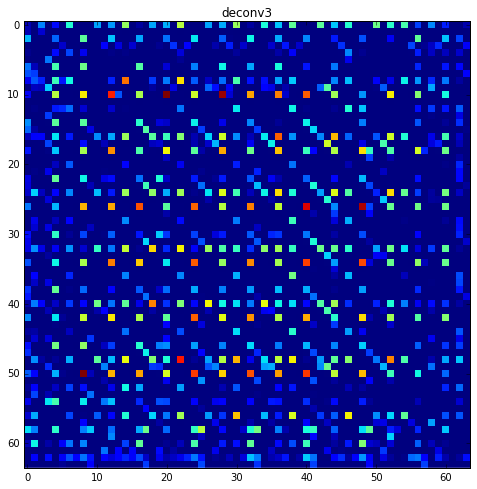

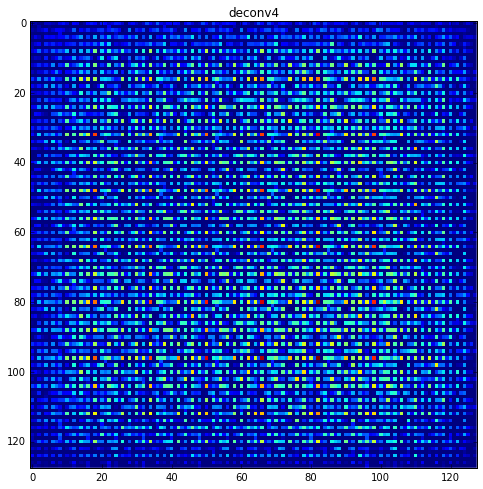

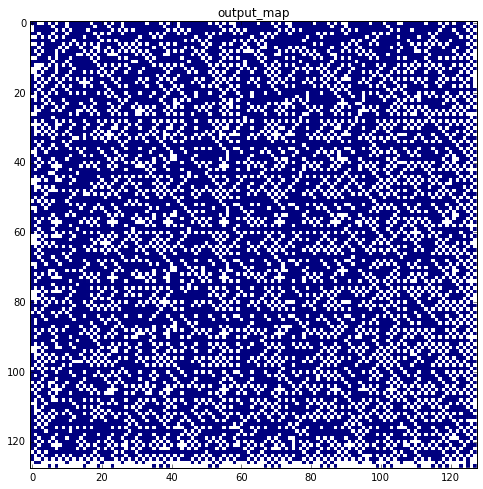

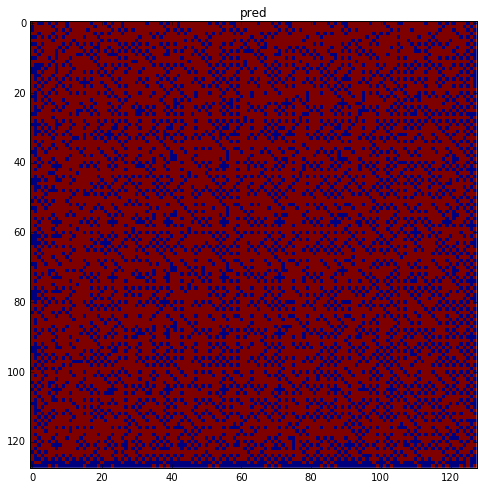

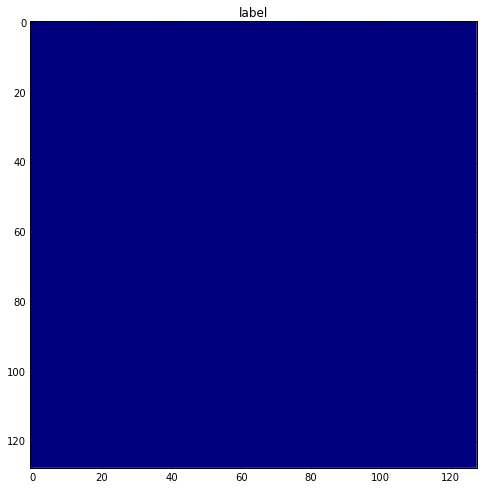

In [10]:

plt.title('input')
plt.imshow(X[0,:,:],interpolation='none')
plt.show()

feed_dict_eval = {
    image_batch_input: X,
    label_batch_input: Y_full,
    keep_prob: 1.0,
    phase_train: False,
} 

if network == 'CROP':
    feed_dict_eval[crop_label_batch_input] = Y

pool_1 = net_parts['pool1'].eval(feed_dict=feed_dict_eval)
pool_2 = net_parts['pool2'].eval(feed_dict=feed_dict_eval)
pool_3 = net_parts['pool3'].eval(feed_dict=feed_dict_eval)
pool_4 = net_parts['pool4'].eval(feed_dict=feed_dict_eval)
last_downconv = net_parts['last_downconv'].eval(feed_dict=feed_dict_eval)

plt.title('pool1')
plt.imshow(pool_1[0,:,:,0],interpolation='none')
plt.show()
plt.title('pool2')
plt.imshow(pool_2[0,:,:,0],interpolation='none')
plt.show()
plt.title('pool3')
plt.imshow(pool_3[0,:,:,0],interpolation='none')
plt.show()
plt.title('pool4')
plt.imshow(pool_4[0,:,:,1],interpolation='none')
plt.show()
plt.title('last_downconv')
plt.imshow(last_downconv[0,:,:,1],interpolation='none')
plt.show()


deconv_1 = net_parts['deconv1'].eval(feed_dict=feed_dict_eval)
deconv_2 = net_parts['deconv2'].eval(feed_dict=feed_dict_eval)
deconv_3 = net_parts['deconv3'].eval(feed_dict=feed_dict_eval)
deconv_4 = net_parts['deconv4'].eval(feed_dict=feed_dict_eval)

plt.title('deconv1')
plt.imshow(deconv_1[0,:,:,1],interpolation='none')
plt.show()
plt.title('deconv2')
plt.imshow(deconv_2[0,:,:,3],interpolation='none')
plt.show()
plt.title('deconv3')
plt.imshow(deconv_3[0,:,:,0],interpolation='none')
plt.show()
plt.title('deconv4')
plt.imshow(deconv_4[0,:,:,0],interpolation='none')
plt.show()

output_map_val = output_map.eval(feed_dict=feed_dict_eval)
result = pred.eval(feed_dict=feed_dict_eval)

plt.title('output_map')
plt.imshow(output_map_val[0,:,:,1],interpolation='none')
plt.show()

plt.title('pred')
plt.imshow(result[0,:,:],interpolation='none')
plt.show()

plt.title('label')
plt.imshow(Y_full[0,:,:],interpolation='none')
plt.show()

In [11]:
import nerveseg_train

if network == 'MINE':
    dice_placeholder = nerveseg_train.dice_coeff(pred, label_batch)
    dice_value = dice_placeholder.eval(feed_dict=feed_dict_eval)

    print(dice_value)

[ 0.83138973]


Filling train dict copy
No label, skipping 31_82
No label, skipping 31_83


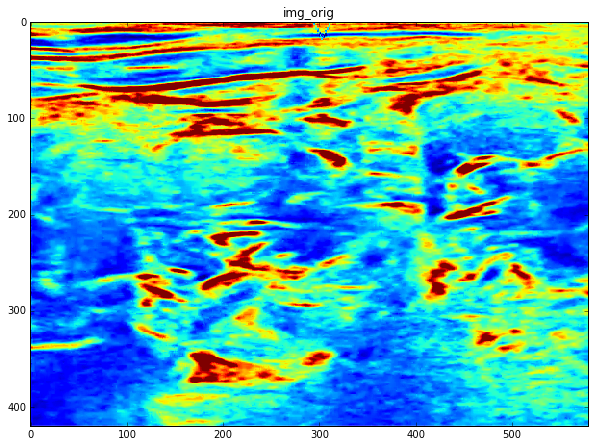

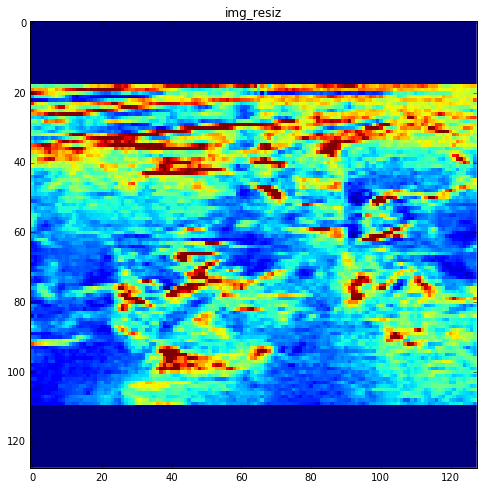

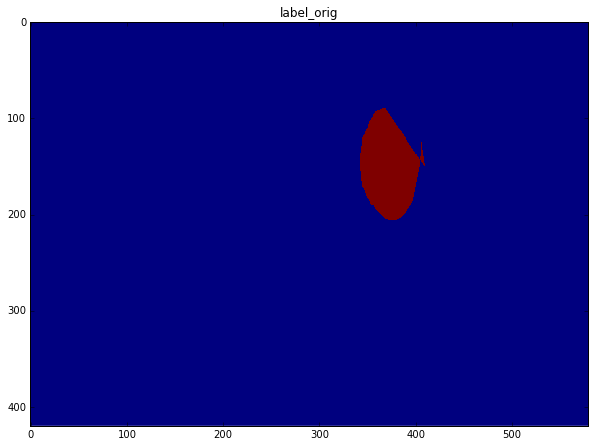

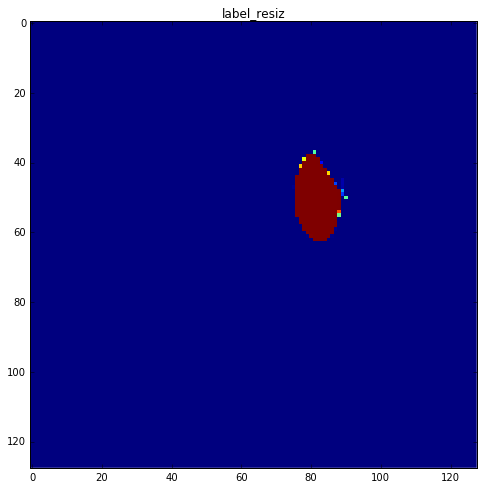

No label, skipping 31_81
No label, skipping 31_86
No label, skipping 31_87
No label, skipping 31_84


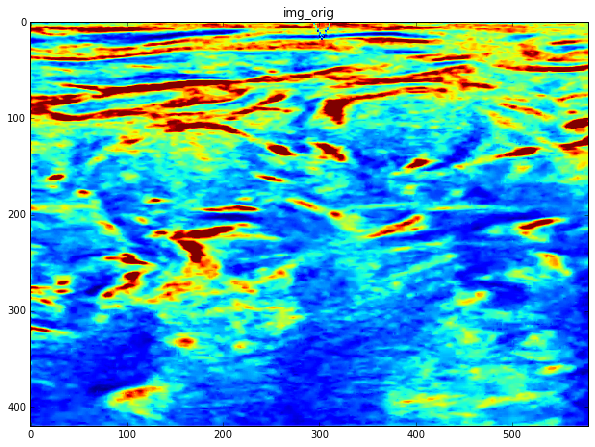

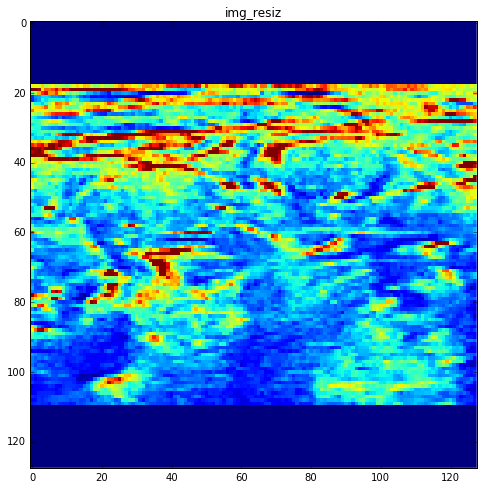

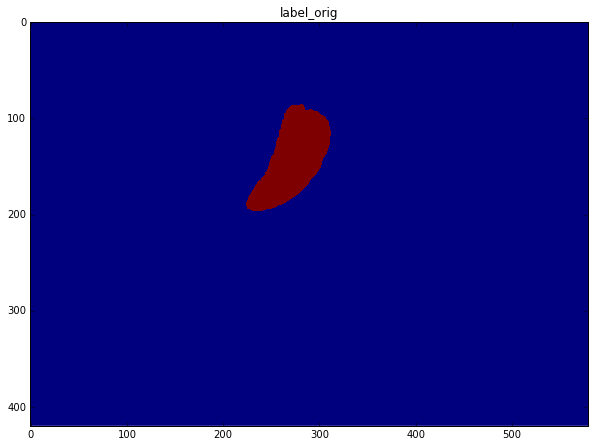

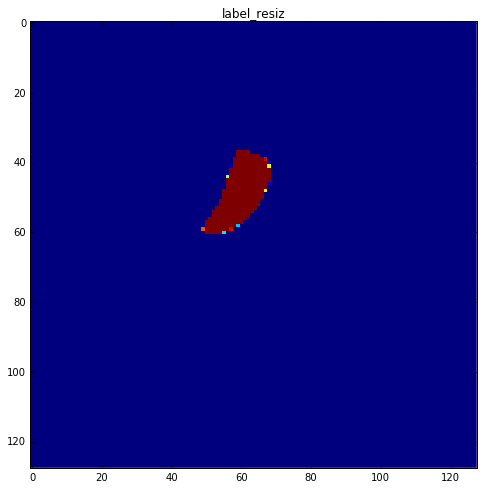

No label, skipping 31_88
No label, skipping 31_89


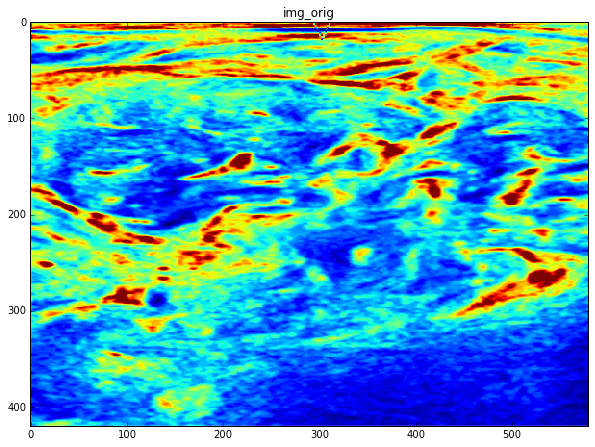

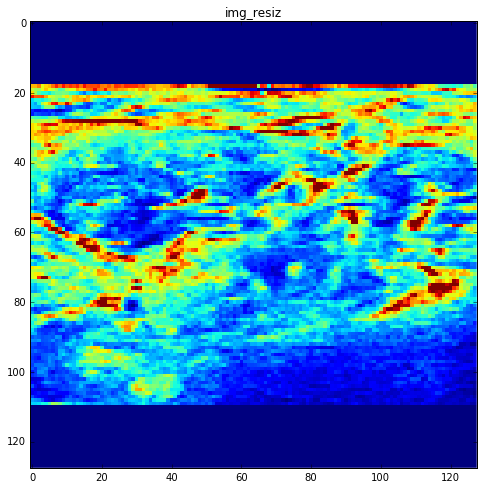

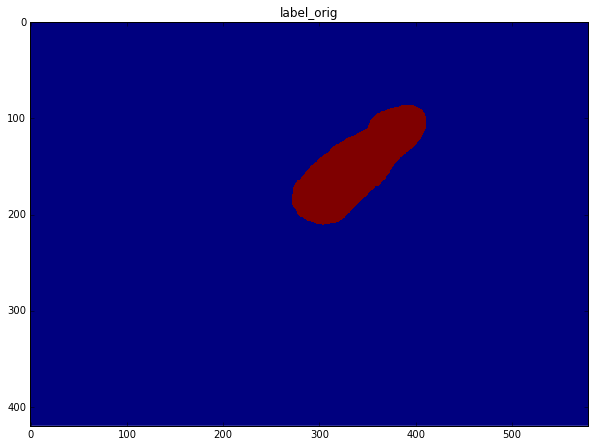

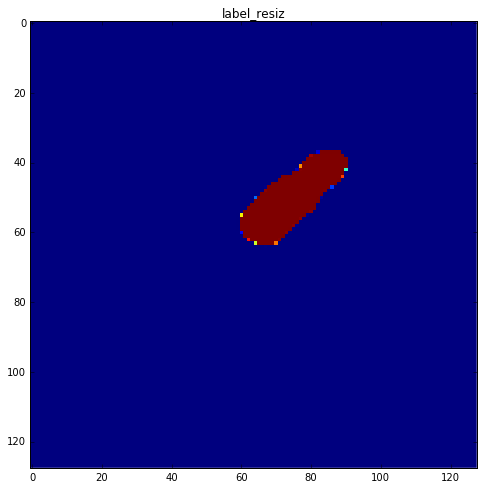

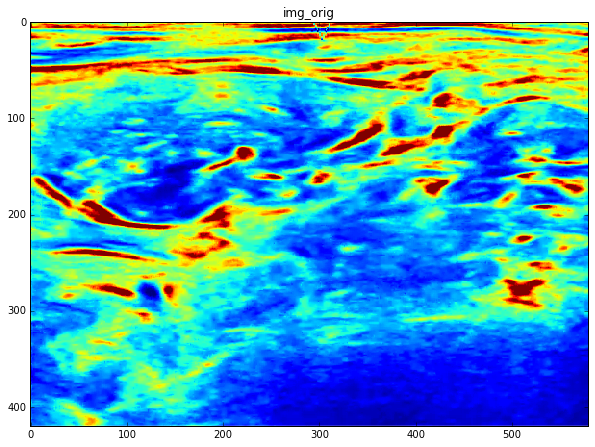

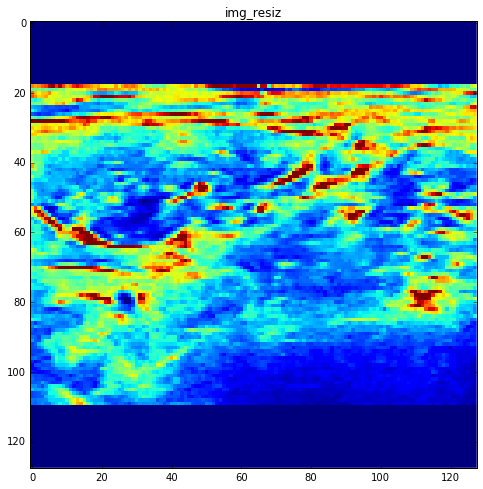

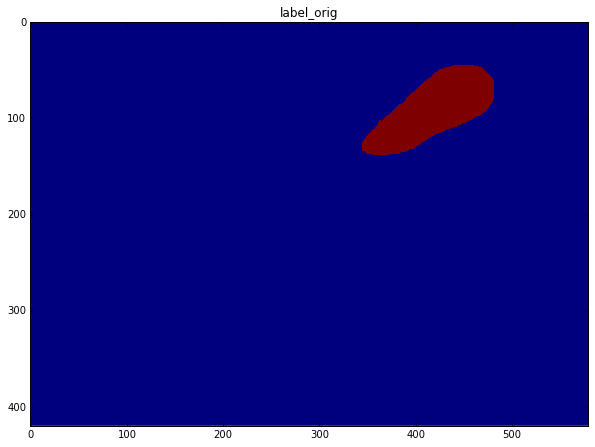

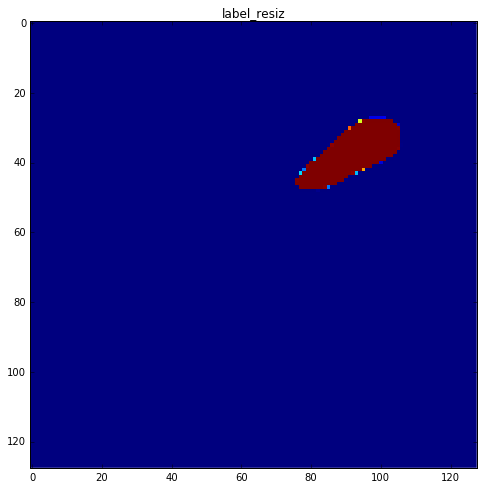

No label, skipping 29_54
No label, skipping 29_55
No label, skipping 29_56


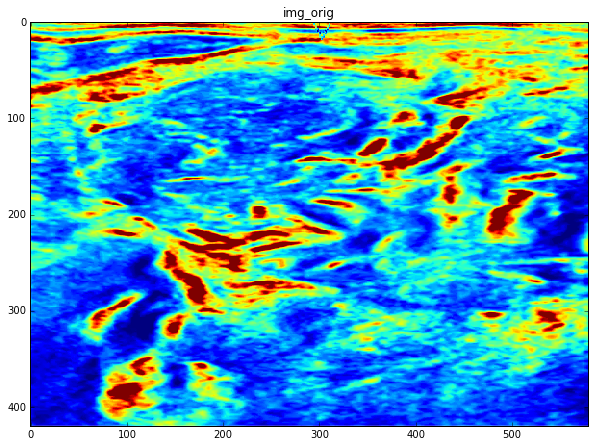

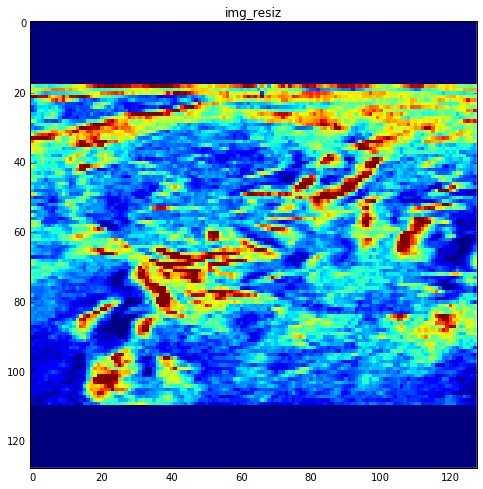

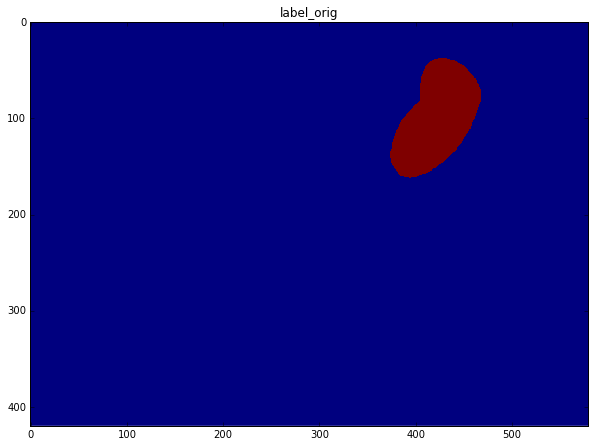

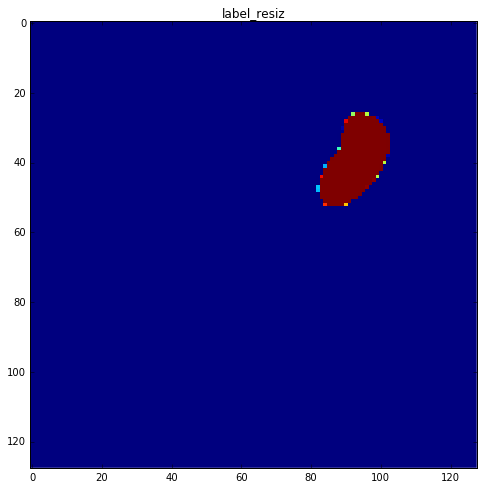

In [12]:
import nerveseg_input
import cv2

TRAIN_DICT = nerveseg_input.read_labeled_image_dir('/home/mtourne/data/nerveseg/train/png')
TRAIN_DICT_COPY = {}

target_dim = nx

img_mean = 99.4930907001
img_std = 56.6518606624

DEBUG=True

def print_img(img, name='No name'):
    plt.title(name)
    plt.imshow(img,interpolation='none')
    plt.show()

def pad_and_resize(img, pad_value=0):
    cols = 580
    rows = 420
    diff = cols - rows
    # add border of zeros to make a square
    img = cv2.copyMakeBorder(img,diff/2,diff/2,0,0,cv2.BORDER_CONSTANT,value=pad_value)
    # redimension the square to 256 pixels
    img = cv2.resize(img, (target_dim, target_dim), interpolation=cv2.INTER_CUBIC)
    return img

def my_deepcopy(train_dict_copy, train_dict):
    print("Filling train dict copy")
    for k, v in train_dict.iteritems():
        train_dict_copy[k] = v

def get_nerve_image(debug=False):
    found_mask = False
    while not found_mask:
        if len(TRAIN_DICT_COPY.keys()) <= 1:
            my_deepcopy(TRAIN_DICT_COPY, TRAIN_DICT)
        (image_name, (image_file, label_file)) = TRAIN_DICT_COPY.popitem()
        img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_file, cv2.IMREAD_GRAYSCALE)
        
        label = np.array(label)
        label_max = np.amax(label)
        if label_max == 0:
            print("No label, skipping {}".format(image_name))
        else:
            found_mask = True
    
    if debug:
        print_img(img, 'img_orig')

    #img = pad_and_resize(img, pad_value=img_mean)
    img = pad_and_resize(img, pad_value=0)
    if debug:
        print_img(img, 'img_resiz')
    
    if debug:
        print_img(label, 'label_orig')
        
    label = pad_and_resize(label)
    if debug: 
        print_img(label, 'label_resiz')
    
    img = np.array(img)
    img = img.astype('float32')
    
    label = label.astype('float32')

    #img -= img_mean
    #img /= img_std
    
    label /= 255.0 # scale masks to [0, 1]  
    
    return img, label

def get_nerve_batch(n_image):
    nx = target_dim
    ny = target_dim 
    X = np.zeros((n_image,nx,ny))
    if network == 'CROP':
        Y = np.zeros((n_image,nx-184,ny-184))
    else: 
        Y = 0
    Y_full = np.zeros((n_image,nx,ny))
    for i in xrange(n_image):
        X[i,:,:],Y_full[i,:,:] = get_nerve_image()
        if network == 'CROP':
            Y[i,:,:] = Y_full[i,92:nx-92,92:ny-92]

    return X,Y,Y_full
    
if DEBUG:
    for i in xrange(5):
        get_nerve_image(debug=True)

Class ratio: 0.0120589042214
cross entropy shape: (16384,)
step: 0, loss: 0.10655285418, dice: [ 0.02046958]


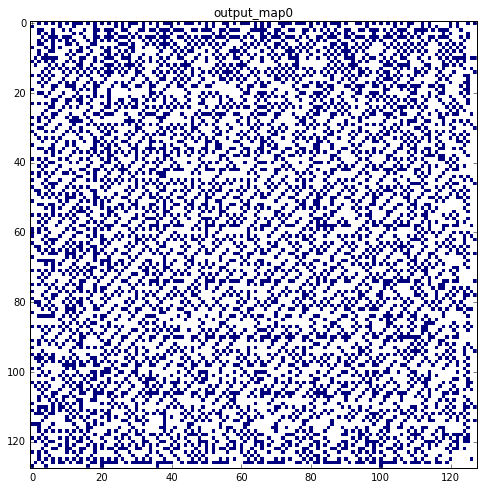

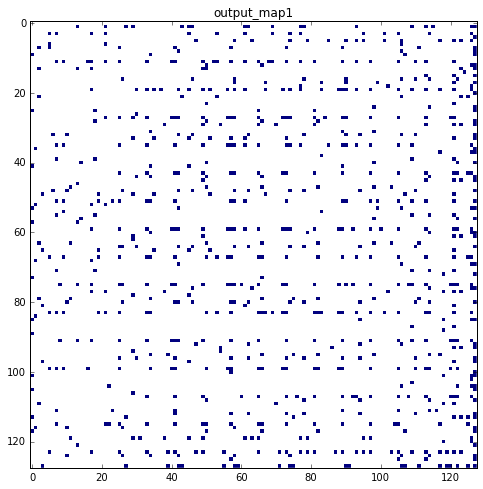

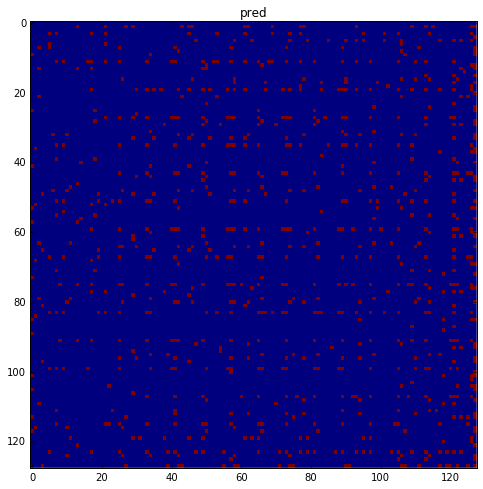

map0 max: nan, map1 max: nan, pred max: 1


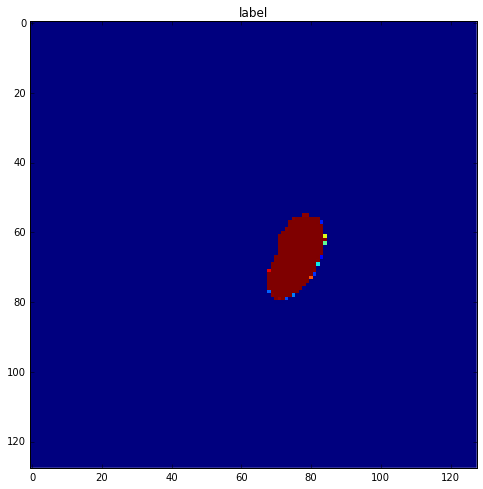

No label, skipping 13_66
No label, skipping 13_67
No label, skipping 13_60
No label, skipping 13_61
No label, skipping 25_111
No label, skipping 12_113
No label, skipping 33_84
No label, skipping 33_85
No label, skipping 33_86
No label, skipping 33_87
No label, skipping 33_80
No label, skipping 33_81
No label, skipping 33_82
No label, skipping 33_83
Filling train dict copy
No label, skipping 33_88
No label, skipping 33_89
No label, skipping 31_82
No label, skipping 31_83
step: 5, loss: 0.019752278924, dice: [ 0.03591878]
No label, skipping 31_81
No label, skipping 31_86
No label, skipping 31_87
No label, skipping 31_84
No label, skipping 31_88
No label, skipping 31_89
No label, skipping 29_54
No label, skipping 29_55
No label, skipping 29_56
No label, skipping 29_50
step: 10, loss: 0.0240328479558, dice: [ 0.08558983]
No label, skipping 29_53
No label, skipping 4_19
No label, skipping 4_14
No label, skipping 4_15
No label, skipping 4_17
No label, skipping 4_10
No label, skipping 4_12
N

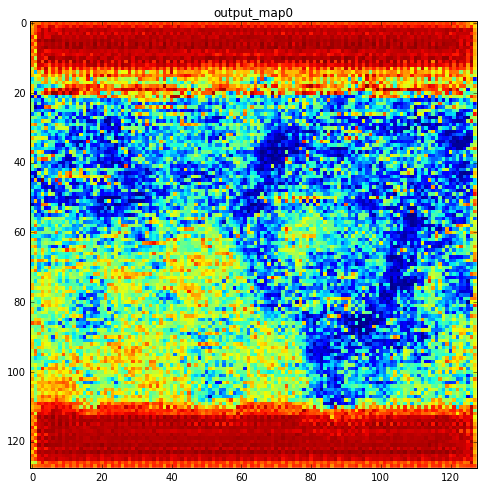

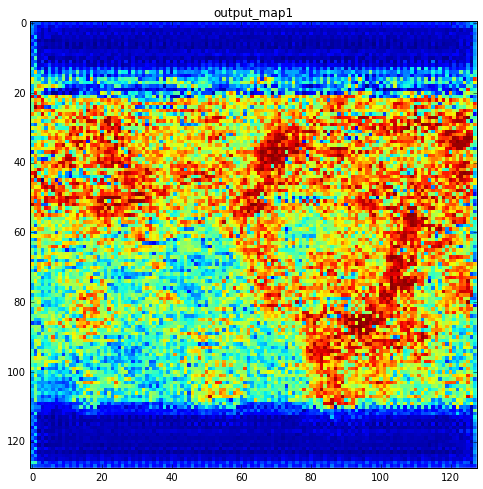

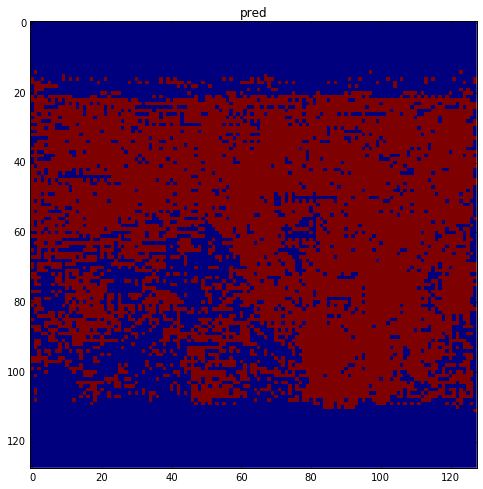

map0 max: 0.970423817635, map1 max: 0.999677062035, pred max: 1


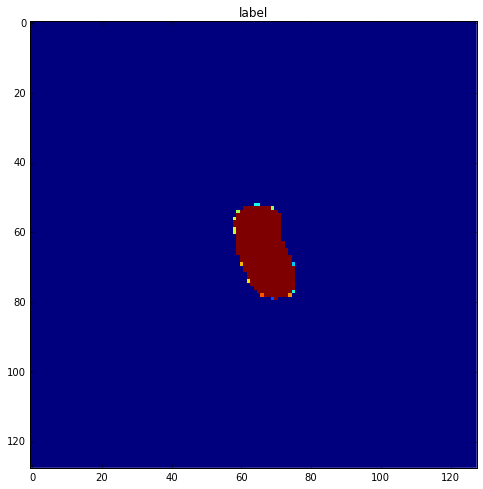

No label, skipping 30_57
No label, skipping 30_54
No label, skipping 30_52
No label, skipping 30_53
No label, skipping 30_50
No label, skipping 30_51
No label, skipping 5_22
No label, skipping 5_20
No label, skipping 5_21
No label, skipping 5_26
No label, skipping 5_27
No label, skipping 5_24
No label, skipping 5_25
No label, skipping 5_29
step: 105, loss: 0.0173848830163, dice: [ 0.11092974]
No label, skipping 45_103
No label, skipping 45_102
No label, skipping 45_101
No label, skipping 45_100
No label, skipping 45_107
No label, skipping 45_106
No label, skipping 45_104
No label, skipping 45_109
No label, skipping 45_108
No label, skipping 17_18
No label, skipping 17_15
No label, skipping 17_14
No label, skipping 11_100
No label, skipping 11_101
No label, skipping 11_102
step: 110, loss: 0.0220995973796, dice: [ 0.10835657]
No label, skipping 39_48
No label, skipping 39_49
No label, skipping 39_46
No label, skipping 39_47
No label, skipping 39_44
No label, skipping 39_45
No label, ski

In [ ]:
background = 1356132911.0
foreground = 16553089.0
ratio = foreground / (background + foreground)
print("Class ratio: {}".format(ratio))
class_weight = [ratio, 1.0 - ratio]

def cross_entropy(y_,output_map, num_classes=2):
    y_ = tf.cast(y_, tf.int32)
    labels = tf.one_hot(y_, num_classes, on_value=1.0, off_value=0.0,
                        dtype=tf.float32)
    return -tf.reduce_mean(labels*tf.log(tf.clip_by_value(output_map,1e-10,1.0)))

def cross_entropy2(y_, output_map, num_classes=2):
   
    
    output_map = tf.reshape(output_map, [-1, num_classes])
    y_ = tf.reshape(y_, [-1])
    
    y_ = tf.cast(y_, tf.int32)
    labels = tf.one_hot(y_, num_classes, on_value=1.0, off_value=0.0,
                        dtype=tf.float32)
    #cross_entropy = -tf.reduce_sum(
    #      labels * tf.log(tf.clip_by_value(output_map,1e-10,1.0)), reduction_indices=[1])
    cross_entropy = -tf.reduce_sum(
        tf.mul(
          labels * tf.log(tf.clip_by_value(output_map,1e-10,1.0)),
          class_weight),
        reduction_indices=[1])
    print("cross entropy shape: {}".format(cross_entropy.get_shape()))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    return cross_entropy_mean

label_batch_one_hot = tf.placeholder("float", shape=[batch, nx, ny, 2])

if network == 'MINE':
    # for 'same' convolution
    cross_entropy_ = cross_entropy2(label_batch_input,output_map)
    #cross_entropy_ = cross_entropy(label_batch_input,output_map)

if network == 'CROP':
    # for 'valid' convolution
    cross_entropy_ = cross_entropy2(crop_label_batch_input, output_map)
    #cross_entropy_ = cross_entropy(crop_label_batch_input, output_map)

learning_rate_ = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy_)
#train_step = tf.train.MomentumOptimizer(learning_rate=learning_rate_,momentum=0.99).minimize(cross_entropy_)

sess.run(tf.initialize_all_variables())

iterations = 10000

display_images = True

def get_labels_one_hot(y_, num_classes=2):
    y_ = tf.cast(y_, tf.int32)
    labels = tf.one_hot(y_, num_classes, on_value=1.0, off_value=0.0,
                        dtype=tf.float32)
    return labels

y_one_hot_ = get_labels_one_hot(label_batch_input)

for i in range(iterations):
    

    # Extract a batch of data
    #X, Y, Y_full = create_batch(nx,ny,1)
    X, _, Y_full = get_nerve_batch(1)
    
    feed_dict_eval = {
        image_batch_input: X,
        label_batch_input: Y_full,
        keep_prob: 1.0,
        phase_train: False,
    } 
    
    feed_dict_train = {
        image_batch_input: X,
        label_batch_input: Y_full,
        keep_prob: 1.0,
        #learning_rate_:np.max(0.01/pow(10.0,(i/15)),1e-6),
        #learning_rate_: 1e-6,
        phase_train: True,
    }
    
    if network == 'CROP':
        feed_dict_eval[crop_label_batch_input] = Y
        feed_dict_train[crop_label_batch_input] = Y
    
    if i % 5 == 0:
        
        dice_value = dice_placeholder.eval(feed_dict=feed_dict_eval)
        loss = cross_entropy_.eval(feed_dict=feed_dict_eval)
        print("step: {}, loss: {}, dice: {}".format(i, loss, dice_value))
        
    if display_images and i % 100 == 0:

        output_map_val = output_map.eval(feed_dict=feed_dict_eval)
        result = pred.eval(feed_dict=feed_dict_eval)

        plt.title('output_map0')
        plt.imshow(output_map_val[0,:,:,0],interpolation='none')
        plt.show()
        
        map0_max = np.amax(output_map_val[0,:,:,0])
        
        plt.title('output_map1')
        plt.imshow(output_map_val[0,:,:,1],interpolation='none')
        plt.show()
        
        map1_max = np.amax(output_map_val[0,:,:,1])

        
        plt.title('pred')
        plt.imshow(result[0,:,:],interpolation='none')
        plt.show()
        
        pred_max = np.amax(result[0,:,:])
        
        print('map0 max: {}, map1 max: {}, pred max: {}'.format(map0_max, map1_max, pred_max))
        
        if network == 'MINE':
            plt.title('label')
            plt.imshow(Y_full[0,:,:],interpolation='none')
            plt.show()
        
        if network == 'CROP':
            plt.title('label_crop')
            plt.imshow(Y[0,:,:],interpolation='none')
            plt.show()
        
        print_one_hot = False
        if print_one_hot:
            label_one_hot = y_one_hot_.eval(feed_dict=feed_dict_eval)
            
            plt.title('one_hot0')
            plt.imshow(label_one_hot[0,:,:,0],interpolation='none')
            plt.show()
            
            plt.title('one_hot1')
            plt.imshow(label_one_hot[0,:,:,1],interpolation='none')
            plt.show()

        extra_debug = False
        if extra_debug: 
            pool_1 = net_parts['pool1'].eval(feed_dict=feed_dict_eval)
            pool_2 = net_parts['pool2'].eval(feed_dict=feed_dict_eval)
            pool_3 = net_parts['pool3'].eval(feed_dict=feed_dict_eval)
            pool_4 = net_parts['pool4'].eval(feed_dict=feed_dict_eval)
            last_downconv = net_parts['last_downconv'].eval(feed_dict=feed_dict_eval)

            plt.title('pool1')
            plt.imshow(pool_1[0,:,:,0],interpolation='none')
            plt.show()
            plt.title('pool2')
            plt.imshow(pool_2[0,:,:,0],interpolation='none')
            plt.show()
            plt.title('pool3')
            plt.imshow(pool_3[0,:,:,0],interpolation='none')
            plt.show()
            plt.title('pool4')
            plt.imshow(pool_4[0,:,:,1],interpolation='none')
            plt.show()
            plt.title('last_downconv')
            plt.imshow(last_downconv[0,:,:,1],interpolation='none')
            plt.show()


            deconv_1 = net_parts['deconv1'].eval(feed_dict=feed_dict_eval)
            deconv_2 = net_parts['deconv2'].eval(feed_dict=feed_dict_eval)
            deconv_3 = net_parts['deconv3'].eval(feed_dict=feed_dict_eval)
            deconv_4 = net_parts['deconv4'].eval(feed_dict=feed_dict_eval)

            plt.title('deconv1')
            plt.imshow(deconv_1[0,:,:,1],interpolation='none')
            plt.show()
            plt.title('deconv2')
            plt.imshow(deconv_2[0,:,:,3],interpolation='none')
            plt.show()
            plt.title('deconv3')
            plt.imshow(deconv_3[0,:,:,0],interpolation='none')
            plt.show()
            plt.title('deconv4')
            plt.imshow(deconv_4[0,:,:,0],interpolation='none')
            plt.show()

    
    train_step.run(feed_dict=feed_dict_train)
        